In [426]:
#Imports
import os
import pretty_midi
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from datetime import datetime
import random

stop_token=[-1,-1,-1,-1]
np.set_printoptions(suppress=True, precision=4)


In [461]:
def extract_notes(midi_file):
    midi_data = pretty_midi.PrettyMIDI(midi_file)
    notes = []
    for instrument in midi_data.instruments:
        if not instrument.is_drum:
            for note in instrument.notes:
                notes.append([note.start, note.pitch, note.velocity, note.end-note.start])
            #notes.append(stop_token)

    return sorted(notes, key=lambda x: x[0])

midi_dir = './smaller-dataset'
all_notes = []

for midi_file in os.listdir(midi_dir):
    if midi_file.endswith('.mid') or midi_file.endswith('.midi'):
        notes = extract_notes(os.path.join(midi_dir, midi_file))
        all_notes.extend(notes)


In [462]:
def normalize_notes(notes):
    notes = np.array(notes)
    max_time = np.max(notes[:, 0])
    max_duration = np.max(notes[:, 3])
    notes[:, 0] /= max_time
    notes[:, 1] /= 127.0
    notes[:, 2] /= 127.0
    notes[:, 3] /= max_duration
    return notes,max_time,max_duration

normalized_notes,max_time,max_duration = normalize_notes(all_notes)
print(max_time,max_duration)

2622.6783854166665 15.12890625


In [463]:
sequence_length = 16
#remember the current n notes
def create_sequences(notes, seq_length):
    sequences = []
    next_notes = []
    
    for i in range(len(notes) - seq_length):
        seq_in = notes[i:i + seq_length]
        #stop token implementation for later
        #seq_in = np.vstack([seq_in, [-1,-1,-1,-1]])
        seq_out = notes[i + seq_length]
        sequences.append(seq_in)
        next_notes.append(seq_out)
    
    return np.array(sequences), np.array(next_notes)

sequences, next_notes = create_sequences(normalized_notes, sequence_length)
print(sequences.shape, next_notes.shape)

(183519, 16, 4) (183519, 4)


In [464]:
class MIDIDataset(Dataset):
    def __init__(self, sequences, next_notes):
        self.sequences = sequences
        self.next_notes = next_notes

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.float32), torch.tensor(self.next_notes[idx], dtype=torch.float32)

dataset = MIDIDataset(sequences, next_notes)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [465]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, input_size)
        self.to(device)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [467]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = 4  # [start_time, pitch, velocity, duration]
hidden_size = 64
num_layers = 2

model = LSTMModel(input_size, hidden_size, num_layers)
model.device=device

print(model.device.type)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 3
#for hyperparameter testing
for epoch in range(num_epochs):
    total_loss = 0.0
    for i, (sequences, next_notes) in enumerate(dataloader):
        sequences = sequences.to(model.device)
        next_notes = next_notes.to(model.device)
        
        #forward pass
        outputs = model(sequences)
        
        #calculate loss
        loss = criterion(outputs, next_notes)
        total_loss += loss.item()
        
        #backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #print average loss for the epoch
    avg_loss = total_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')


cuda
Epoch [1/3], Average Loss: 0.0055
Epoch [2/3], Average Loss: 0.0052
Epoch [3/3], Average Loss: 0.0051


In [468]:
filename = f"./models/model_{datetime.now():%d_%m_%H_%M}.pth"
torch.save(model.state_dict(), filename)
print('Model saved')

Model saved


In [469]:
def generate_music(model, start_sequence, length, stop_token=[-1, -1, -1, -1]):
    model.eval()
    generated_sequence = start_sequence.detach().cpu().numpy().tolist()
    current_sequence = start_sequence.detach().cpu().numpy()

    for _ in range(length):
        current_sequence_tensor = torch.tensor(current_sequence, dtype=torch.float32).unsqueeze(0).to(model.device)
        next_note = model(current_sequence_tensor).detach().cpu().numpy().squeeze(0).tolist()
        #check for stop token, next note is not generating this so take a look at that later
        #if np.array_equal(next_note, stop_token):
        #    break
        generated_sequence.append(next_note)
        current_sequence = np.append(current_sequence[1:], [next_note], axis=0)
    
    return np.array(generated_sequence[sequence_length:])

# generate the sequence using your model
# start with the first sequence from your dataset
#start_sequence = sequences[0]
#or pick random
start_sequence = random.choice(sequences)
#generate n notes
generated_sequence = generate_music(model, start_sequence, 52)
print(generated_sequence.shape)



(52, 4)


In [470]:
# define the denormalization function
def denormalize_notes(normalized_notes, max_time, max_duration):
    denormalized_notes = np.zeros_like(normalized_notes)
    denormalized_notes[:, 0] = normalized_notes[:, 0] * max_time
    denormalized_notes[:, 1] = normalized_notes[:, 1] * 127
    denormalized_notes[:, 2] = normalized_notes[:, 2] * 127
    denormalized_notes[:, 3] = normalized_notes[:, 3] * max_duration
    return denormalized_notes

# define the MIDI conversion function
def sequence_to_midi(denormalized_sequence, output_path):
    midi = pretty_midi.PrettyMIDI()
    #program is piano
    instrument = pretty_midi.Instrument(program=0)
    
    for i,note in enumerate(denormalized_sequence):
        #First note starts at 0
        start = 0.000
        pitch = int(note[1])
        velocity = int(note[2])
        duration = note[3]
        #and the next notes should take the previous notes starting point and add the duration of self
        if i>0:
            start=instrument.notes[i-1].start + duration
        midi_note = pretty_midi.Note(
            velocity=velocity,
            pitch=pitch,
            start=start,
            end=start+duration
            #end=start+duration+1.5
        )
        instrument.notes.append(midi_note)
    print('Total notes:',len(instrument.notes))
    midi.instruments.append(instrument)
    midi.write(output_path)


#denormalize the generated sequence
denormalized_sequence = denormalize_notes(generated_sequence, max_time, max_duration)
#convert the denormalized sequence to a MIDI file
output_path = f"./generated_music_{datetime.now():%d_%m_%H_%M}.mid"
sequence_to_midi(denormalized_sequence, output_path)

print(f"Generated MIDI file saved to {output_path}")


Total notes: 52
Generated MIDI file saved to ./generated_music_17_06_16_57.mid


In [471]:
# Load MIDI file
midi_file = output_path
midi_data = pretty_midi.PrettyMIDI(midi_file)

#extract notes from the first instrument (assuming there's only one)
notes = midi_data.instruments[0].notes

#extract start times, pitches, and durations
start_times = np.array([note.start for note in notes])
end_times = np.array([note.end for note in notes])
durations = end_times - start_times
pitches = np.array([note.pitch for note in notes])

#normalize the pitch column (second column) to [0, 1] range
min_pitch = 0  #MIDI pitch minimum value
max_pitch = 127  #MIDI pitch maximum value
normalized_pitches = (pitches - min_pitch) / (max_pitch - min_pitch)

#function to map MIDI pitch number to note name
def midi_to_note_name(midi_num):
    note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    octave = (midi_num // 12) - 1
    note = note_names[midi_num % 12]
    return f"{note}{octave}"


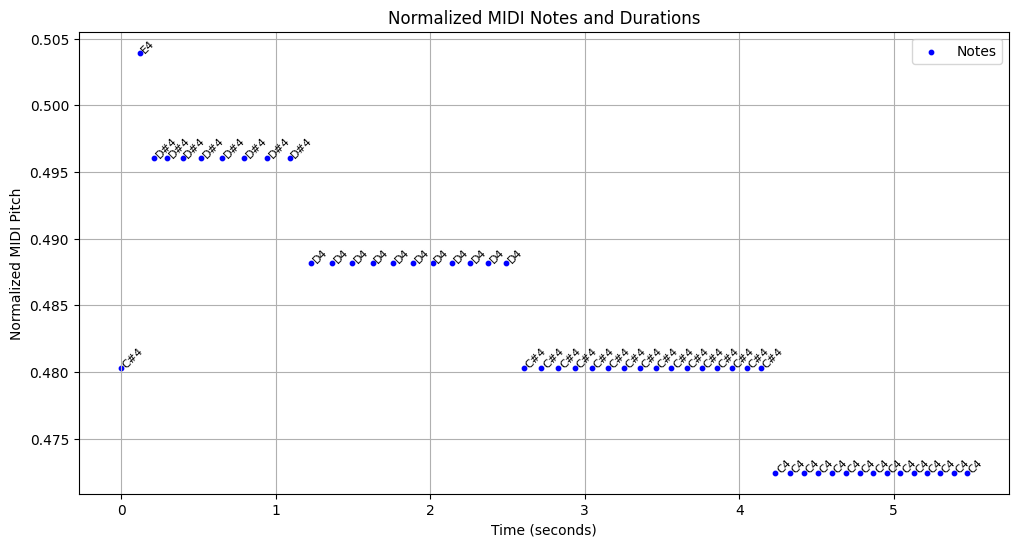

In [472]:
#map normalized pitch values back to note names
note_names = [midi_to_note_name(int(pitch * 127)) for pitch in normalized_pitches]

plt.figure(figsize=(12, 6))
plt.scatter(start_times, normalized_pitches, s=10, label='Notes', color='blue')
plt.xlabel('Time (seconds)')
plt.ylabel('Normalized MIDI Pitch')
plt.title('Normalized MIDI Notes and Durations')
plt.legend()
plt.grid(True)

#labels
for i, txt in enumerate(note_names):
    plt.annotate(txt, (start_times[i], normalized_pitches[i]), fontsize=8, rotation=45)

plt.show()